In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict

import tqdm

%matplotlib inline

/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import sherlock

In [3]:
df = pd.read_csv("./data/Dataset_Anomaly_Init_R2.csv")  # dataset
sec = pd.read_csv("./data/Dataset_Anomaly_Secret_R2.csv")  # megoldas

In [4]:
df.head()

1   2   3  4  5   6  7  8  9  10  11  12  13  14  15  16  ID
0  8  10  12  8  9  10  6  2  5   9   5   7   8   7   2   8   0
1  4   2   5  3  3   8  6  6  4   6   7   8   7   6   2   6   1
2  2   0   3  1  1   7  8  4  0   7   8   8   7   9   0   8   2
3  2   3   3  2  2   7  9  5  4   7   6   7   5   9   2   7   3
4  5   9   8  7  5   7  9  2  4  10   5   6   5   9   1   7   4

In [5]:
df.shape

(2467, 17)

In [6]:
expert = sherlock.Sherlock(
    sec, 111
)  # kezzel irt script, ami az anomalianak utananezo szakembert szimulalja

In [7]:
# 0. lepes - veletelen minta, hogy legyen elkepzelesunk az anomalia - nem anomalia aranyrol

In [8]:
random_sample = df.sample(10, random_state=1)

In [9]:
expert.investigate(random_sample["ID"])

	Nyomozás eredménye	481	->	ok
	Nyomozás eredménye	1937	->	ok
	Nyomozás eredménye	280	->	csalás
	Nyomozás eredménye	440	->	ok
	Nyomozás eredménye	107	->	ok
	Nyomozás eredménye	768	->	ok
	Nyomozás eredménye	2209	->	ok
	Nyomozás eredménye	1233	->	ok
	Nyomozás eredménye	1730	->	ok
	Nyomozás eredménye	2041	->	ok


In [10]:
expert.stat()

Adathalmaz mérete   = 2467
Ismert esetek száma = 10 		max: 111
  Ismert csalás = 1
  Felderítési arány = 10.0%


In [11]:
df = expert.add_label(df, "info")

In [12]:
df

1   2   3  4  5   6   7  8  9  10  11  12  13  14  15  16    ID  \
0      8  10  12  8  9  10   6  2  5   9   5   7   8   7   2   8     0   
1      4   2   5  3  3   8   6  6  4   6   7   8   7   6   2   6     1   
2      2   0   3  1  1   7   8  4  0   7   8   8   7   9   0   8     2   
3      2   3   3  2  2   7   9  5  4   7   6   7   5   9   2   7     3   
4      5   9   8  7  5   7   9  2  4  10   5   6   5   9   1   7     4   
...   ..  ..  .. .. ..  ..  .. .. ..  ..  ..  ..  ..  ..  ..  ..   ...   
2462   3   7   4  5  4   8   6  5  4   7   7   8   7   5   2   7  2462   
2463   7   7   7  5  5   6  10  4  3   8   7   7   9  13   3   4  2463   
2464  10  10   9  8  9   5  11  4  3   8   7   7  10  12   4   5  2464   
2465   3   5   4  4  4   8   6  6  4   7   7   8   7   5   2   7  2465   
2466   5   6   5  4  4   3  10  2  3  10   9   8   6  11   2   6  2466   

         info  
0     no_info  
1     no_info  
2     no_info  
3     no_info  
4     no_info  
...       ...  
2462  no_info  
2463  no_info  
2464  no_info  
2465  no_info  
2466  no_info  

[2467 rows x 18 columns]

In [13]:
df["info"].value_counts()

no_info    2457
ok            9
csalás        1
Name: info, dtype: int64

In [14]:
# 1. ISO FOREST

In [15]:
model = IsolationForest(random_state=1)

In [16]:
X_cols = [str(col) for col in range(1, 17)]

In [17]:
X = df.loc[:, X_cols]

In [18]:
X.head()

1   2   3  4  5   6  7  8  9  10  11  12  13  14  15  16
0  8  10  12  8  9  10  6  2  5   9   5   7   8   7   2   8
1  4   2   5  3  3   8  6  6  4   6   7   8   7   6   2   6
2  2   0   3  1  1   7  8  4  0   7   8   8   7   9   0   8
3  2   3   3  2  2   7  9  5  4   7   6   7   5   9   2   7
4  5   9   8  7  5   7  9  2  4  10   5   6   5   9   1   7

In [19]:
scaler = StandardScaler()

In [20]:
X_scaled = scaler.fit_transform(X)

In [21]:
scaled_df = pd.DataFrame(
    X_scaled, index=df.index, columns=[col + "_scaled" for col in X_cols]
)

In [22]:
df = pd.concat([df, scaled_df], axis=1)

In [23]:
df.head()

1   2   3  4  5   6  7  8  9  10  ...  7_scaled  8_scaled  9_scaled  \
0  8  10  12  8  9  10  6  2  5   9  ... -0.966892 -0.961443  1.019124   
1  4   2   5  3  3   8  6  6  4   6  ... -0.966892  0.184116  0.444060   
2  2   0   3  1  1   7  8  4  0   7  ...  0.107820 -0.388663 -1.856195   
3  2   3   3  2  2   7  9  5  4   7  ...  0.645176 -0.102274  0.444060   
4  5   9   8  7  5   7  9  2  4  10  ...  0.645176 -0.961443  0.444060   

   10_scaled  11_scaled  12_scaled  13_scaled 14_scaled  15_scaled  16_scaled  
0   0.743981  -0.919737  -0.575949   0.541410 -0.587294   0.073593   0.568823  
1  -0.749024   0.012853   0.162547   0.090022 -1.046228   0.073593  -0.954831  
2  -0.251356   0.479148   0.162547   0.090022  0.330574  -0.921228   0.568823  
3  -0.251356  -0.453442  -0.575949  -0.812756  0.330574   0.073593  -0.193004  
4   1.241649  -0.919737  -1.314445  -0.812756  0.330574  -0.423817  -0.193004  

[5 rows x 34 columns]

In [24]:
X_cols = [col + "_scaled" for col in X_cols]

In [25]:
X = df.loc[:, X_cols]

In [26]:
X.head()

1_scaled  2_scaled  3_scaled  4_scaled  5_scaled  6_scaled  7_scaled  \
0  1.512175  0.859290  2.498127  1.248786  1.780931  1.559530 -0.966892   
1 -0.380537 -1.509278 -0.533081 -1.075259 -0.585437  0.549592 -0.966892   
2 -1.326893 -2.101420 -1.399140 -2.004877 -1.374226  0.044622  0.107820   
3 -1.326893 -1.213207 -1.399140 -1.540068 -0.979832  0.044622  0.645176   
4  0.092641  0.563219  0.766008  0.783977  0.203352  0.044622  0.645176   

   8_scaled  9_scaled  10_scaled  11_scaled  12_scaled  13_scaled  14_scaled  \
0 -0.961443  1.019124   0.743981  -0.919737  -0.575949   0.541410  -0.587294   
1  0.184116  0.444060  -0.749024   0.012853   0.162547   0.090022  -1.046228   
2 -0.388663 -1.856195  -0.251356   0.479148   0.162547   0.090022   0.330574   
3 -0.102274  0.444060  -0.251356  -0.453442  -0.575949  -0.812756   0.330574   
4 -0.961443  0.444060   1.241649  -0.919737  -1.314445  -0.812756   0.330574   

   15_scaled  16_scaled  
0   0.073593   0.568823  
1   0.073593  -0.954831  
2  -0.921228   0.568823  
3   0.073593  -0.193004  
4  -0.423817  -0.193004

In [27]:
model.fit(X)

IsolationForest(random_state=1)

In [28]:
df["pred_iso"] = model.predict(X)

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [29]:
df["pred_iso"].value_counts()

 1    2203
-1     264
Name: pred_iso, dtype: int64

In [30]:
df["pred_iso_score"] = model.decision_function(X)

<AxesSubplot:>

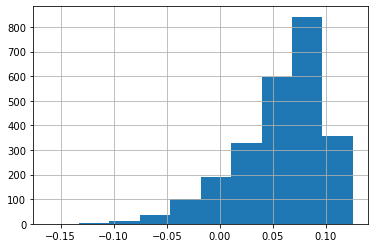

In [31]:
df["pred_iso_score"].hist()

<AxesSubplot:>

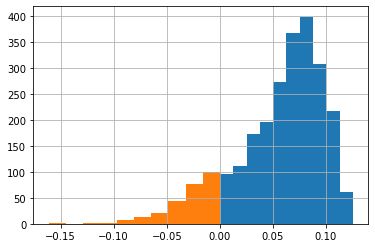

In [32]:
df.loc[df["pred_iso"] == 1, "pred_iso_score"].hist()
df.loc[df["pred_iso"] == -1, "pred_iso_score"].hist()

In [33]:
iso_to_check = df.sort_values("pred_iso_score").head(10)

In [34]:
expert.investigate(iso_to_check["ID"])

	Nyomozás eredménye	1106	->	csalás
	Nyomozás eredménye	2460	->	csalás
	Nyomozás eredménye	2144	->	csalás
	Nyomozás eredménye	2279	->	ok
	Nyomozás eredménye	950	->	ok
	Nyomozás eredménye	2033	->	csalás
	Nyomozás eredménye	908	->	csalás
	Nyomozás eredménye	1455	->	csalás
	Nyomozás eredménye	2129	->	csalás
	Nyomozás eredménye	1854	->	ok


In [35]:
expert.stat()

Adathalmaz mérete   = 2467
Ismert esetek száma = 20 		max: 111
  Ismert csalás = 8
  Felderítési arány = 40.0%


In [36]:
df = expert.add_label(df, "info")

In [37]:
df["info"].value_counts()

no_info    2447
ok           12
csalás        8
Name: info, dtype: int64

In [38]:
# 2/a klaszterezes - kmeans

In [39]:
sse_list = []
for i in tqdm.tqdm(range(1, 15)):
    kmeans = KMeans(n_clusters=i, random_state=1)
    kmeans.fit(X)
    sse_list.append(kmeans.inertia_)

100%|██████████| 14/14 [00:09<00:00,  1.55it/s]


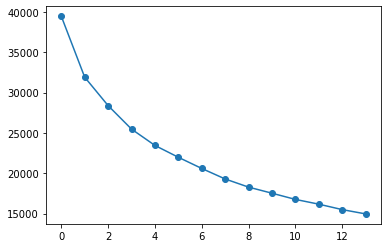

In [40]:
plt.plot(sse_list, marker="o")

In [41]:
kmeans = KMeans(n_clusters=6, random_state=1)

In [42]:
df["cluster_kmeans"] = kmeans.fit_predict(X)

In [43]:
df["cluster_kmeans"].value_counts()

1    563
0    479
2    470
3    411
4    302
5    242
Name: cluster_kmeans, dtype: int64

In [44]:
df.groupby(["cluster_kmeans", "info"]).size().reset_index()

cluster_kmeans     info    0
0                0  no_info  479
1                1   csalás    6
2                1  no_info  555
3                1       ok    2
4                2  no_info  468
5                2       ok    2
6                3   csalás    1
7                3  no_info  407
8                3       ok    3
9                4   csalás    1
10               4  no_info  299
11               4       ok    2
12               5  no_info  239
13               5       ok    3

In [45]:
cluster_df = df.loc[df["cluster_kmeans"] == 1, :].reset_index(drop=True)

In [46]:
X_cluster = cluster_df.loc[:, X_cols]

In [47]:
cluster_df["sub_cluster"] = kmeans.fit_predict(X_cluster)

In [48]:
cluster_df.groupby(["sub_cluster", "info"]).size()

sub_cluster  info   
0            no_info    161
             ok           1
1            no_info     97
2            no_info    104
             ok           1
3            csalás       2
             no_info     11
4            csalás       4
             no_info    101
5            no_info     81
dtype: int64

<AxesSubplot:xlabel='sub_cluster'>

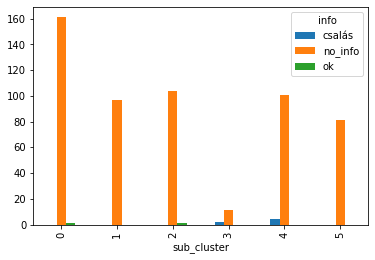

In [49]:
cluster_df.groupby(["sub_cluster", "info"]).size().unstack().plot(kind="bar")

In [50]:
cluster_to_check = cluster_df.loc[
    (cluster_df["sub_cluster"] == 3) & (cluster_df["info"] == "no_info"), :
]

In [51]:
expert.investigate(cluster_to_check["ID"])

	Nyomozás eredménye	127	->	csalás
	Nyomozás eredménye	208	->	csalás
	Nyomozás eredménye	360	->	csalás
	Nyomozás eredménye	553	->	csalás
	Nyomozás eredménye	629	->	csalás
	Nyomozás eredménye	828	->	csalás
	Nyomozás eredménye	1049	->	csalás
	Nyomozás eredménye	1069	->	csalás
	Nyomozás eredménye	1386	->	csalás
	Nyomozás eredménye	1512	->	csalás
	Nyomozás eredménye	2399	->	csalás


In [52]:
df = expert.add_label(df, "info")

In [53]:
df["info"].value_counts()

no_info    2436
csalás       19
ok           12
Name: info, dtype: int64

In [54]:
expert.stat()

Adathalmaz mérete   = 2467
Ismert esetek száma = 31 		max: 111
  Ismert csalás = 19
  Felderítési arány = 61.3%


In [55]:
# 2/b klaszterezes - dbscan + nearestneighbor

In [56]:
model = DBSCAN(eps=0.5)

model.fit(X)

df["dbscan_cluster"] = model.labels_

In [57]:
df["dbscan_cluster"].value_counts()

-1     2252
 6       28
 1       22
 3       19
 8       19
 5       14
 12      14
 4       12
 9       11
 11      11
 2        8
 13       8
 17       8
 18       7
 7        6
 0        6
 10       6
 15       6
 14       5
 16       5
Name: dbscan_cluster, dtype: int64

In [58]:
# hatarozzuk meg optimalist epszilont

In [59]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

<AxesSubplot:>

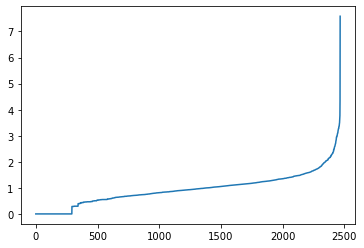

In [60]:
# az optimalis epszilon az az y(tavolsag) pont, ahol a gorbe meredeken elkezd emelkedni
pd.Series(distances[:, 1]).sort_values().reset_index(drop=True).plot()

In [61]:
df["nearest_distance"] = distances[:, 1]

In [62]:
nearest_to_check = df.loc[df["info"] == "no_info", :].sort_values(
    "nearest_distance", ascending=False
)[:10]

In [63]:
expert.investigate(nearest_to_check["ID"])

	Nyomozás eredménye	1542	->	csalás
	Nyomozás eredménye	2131	->	csalás
	Nyomozás eredménye	2178	->	csalás
	Nyomozás eredménye	1578	->	csalás
	Nyomozás eredménye	1382	->	csalás
	Nyomozás eredménye	1047	->	csalás
	Nyomozás eredménye	86	->	csalás
	Nyomozás eredménye	2361	->	csalás
	Nyomozás eredménye	92	->	csalás
	Nyomozás eredménye	1385	->	csalás


In [64]:
expert.stat()

Adathalmaz mérete   = 2467
Ismert esetek száma = 41 		max: 111
  Ismert csalás = 29
  Felderítési arány = 70.7%


In [65]:
df = expert.add_label(df, "info")

<AxesSubplot:>

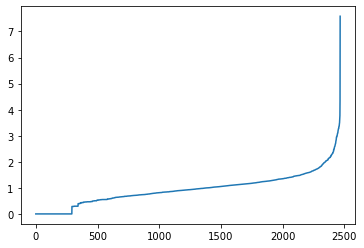

In [66]:
df["nearest_distance"].sort_values().reset_index(drop=True).plot()

In [67]:
model = DBSCAN(eps=3)

model.fit(X)

df["cluster_dbscan"] = model.labels_

In [68]:
df["cluster_dbscan"].value_counts()

 0    2418
-1      44
 1       5
Name: cluster_dbscan, dtype: int64

In [69]:
dbscan_to_check = df.loc[
    (df["cluster_dbscan"] != 0) & (df["info"] == "no_info"), :
].head(10)

In [70]:
expert.investigate(dbscan_to_check["ID"])

	Nyomozás eredménye	419	->	csalás
	Nyomozás eredménye	592	->	csalás
	Nyomozás eredménye	683	->	csalás
	Nyomozás eredménye	869	->	csalás
	Nyomozás eredménye	948	->	csalás
	Nyomozás eredménye	997	->	csalás
	Nyomozás eredménye	1035	->	csalás
	Nyomozás eredménye	1217	->	csalás
	Nyomozás eredménye	1322	->	csalás
	Nyomozás eredménye	1337	->	csalás


In [71]:
df = expert.add_label(df, "info")

In [72]:
df["info"].value_counts()

no_info    2416
csalás       39
ok           12
Name: info, dtype: int64

In [73]:
expert.stat()

Adathalmaz mérete   = 2467
Ismert esetek száma = 51 		max: 111
  Ismert csalás = 39
  Felderítési arány = 76.5%


In [74]:
# 3. felugyelt tanulas - logreg

In [75]:
model = LogisticRegression()

In [76]:
info_map = {value: i for i, value in enumerate(df["info"].unique())}

In [77]:
df["info_num"] = df["info"].map(info_map)

In [78]:
y_col = "info_num"

In [79]:
X = df.loc[:, X_cols]

In [80]:
y = df.loc[:, y_col]

In [81]:
y.value_counts()

0    2416
1      39
2      12
Name: info_num, dtype: int64

In [82]:
pred_proba = cross_val_predict(model, X, y, cv=4, method="predict_proba")

In [83]:
pred_proba

array([[9.79496125e-01, 2.28701880e-05, 2.04810044e-02],
       [9.93229782e-01, 1.25402947e-04, 6.64481516e-03],
       [9.95256873e-01, 1.26376256e-05, 4.73048960e-03],
       ...,
       [9.98540512e-01, 6.54035676e-06, 1.45294796e-03],
       [9.99272616e-01, 9.66545752e-05, 6.30728950e-04],
       [9.97850698e-01, 1.07290196e-03, 1.07640000e-03]])

In [84]:
df.loc[:, ["pred_noinfo", "pred_cs", "pred_ok"]] = pred_proba

In [85]:
df.groupby("info")["pred_cs", "pred_noinfo", "pred_ok"].mean()

/tmp/ipykernel_35258/672262353.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby('info')['pred_cs', 'pred_noinfo', 'pred_ok'].mean()


pred_cs  pred_noinfo   pred_ok
info                                    
csalás   0.522762     0.473851  0.003386
no_info  0.006718     0.988849  0.004433
ok       0.002136     0.973360  0.024504

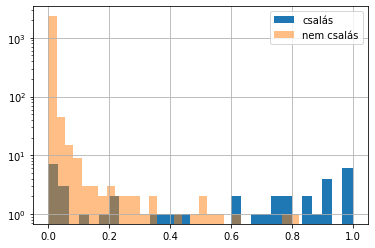

In [86]:
df.loc[df["info"] == "csalás", "pred_cs"].hist(bins=30, label="csalás")
df.loc[df["info"] != "csalás", "pred_cs"].hist(bins=30, label="nem csalás", alpha=0.5)
plt.yscale("log")
plt.legend()

In [87]:
logreg_to_check = (
    df.loc[df["info"] == "no_info"].sort_values("pred_cs", ascending=False).head(10)
)

In [88]:
expert.investigate(logreg_to_check["ID"])

	Nyomozás eredménye	1052	->	csalás
	Nyomozás eredménye	2098	->	csalás
	Nyomozás eredménye	1666	->	csalás
	Nyomozás eredménye	2438	->	csalás
	Nyomozás eredménye	2122	->	csalás
	Nyomozás eredménye	1592	->	csalás
	Nyomozás eredménye	1642	->	csalás
	Nyomozás eredménye	1885	->	csalás
	Nyomozás eredménye	2334	->	csalás
	Nyomozás eredménye	1151	->	csalás


In [89]:
df = expert.add_label(df, "info")

In [90]:
df["info"].value_counts()

no_info    2406
csalás       49
ok           12
Name: info, dtype: int64

In [91]:
expert.stat()

Adathalmaz mérete   = 2467
Ismert esetek száma = 61 		max: 111
  Ismert csalás = 49
  Felderítési arány = 80.3%


In [92]:
# 4. felugyelt tanulas - kombinalt

In [93]:
df["pred_iso"].value_counts()

 1    2203
-1     264
Name: pred_iso, dtype: int64

In [94]:
df["cluster_dbscan"].value_counts()

 0    2418
-1      44
 1       5
Name: cluster_dbscan, dtype: int64

In [95]:
df["pred_cs"].value_counts()

0.000205    4
0.000142    3
0.003755    3
0.000124    3
0.000255    3
           ..
0.000001    1
0.007339    1
0.000226    1
0.000011    1
0.001073    1
Name: pred_cs, Length: 2393, dtype: int64

In [96]:
df["combined_score"] = (
    (df["pred_iso"] * -1)
    + (df["cluster_dbscan"].apply(lambda x: 1 if x != 0 else -1))
    + (df["pred_cs"] - df["pred_ok"])
)

In [97]:
combined_to_check = (
    df.loc[df["info"] == "no_info", :]
    .sort_values("combined_score", ascending=False)
    .head(50)
)

In [98]:
expert.investigate(combined_to_check["ID"])

	Nyomozás eredménye	2219	->	csalás
	Nyomozás eredménye	2197	->	csalás
	Nyomozás eredménye	1535	->	csalás
	Nyomozás eredménye	1965	->	csalás
	Nyomozás eredménye	2283	->	csalás
	Nyomozás eredménye	1942	->	csalás
	Nyomozás eredménye	1522	->	csalás
	Nyomozás eredménye	929	->	csalás
	Nyomozás eredménye	676	->	csalás
	Nyomozás eredménye	1135	->	ok
	Nyomozás eredménye	361	->	csalás
	Nyomozás eredménye	244	->	csalás
	Nyomozás eredménye	593	->	csalás
	Nyomozás eredménye	2066	->	csalás
	Nyomozás eredménye	733	->	csalás
	Nyomozás eredménye	1571	->	csalás
	Nyomozás eredménye	1189	->	ok
	Nyomozás eredménye	507	->	csalás
	Nyomozás eredménye	1452	->	csalás
	Nyomozás eredménye	1828	->	ok
	Nyomozás eredménye	2157	->	csalás
	Nyomozás eredménye	1457	->	csalás
	Nyomozás eredménye	1253	->	csalás
	Nyomozás eredménye	1565	->	csalás
	Nyomozás eredménye	760	->	ok
	Nyomozás eredménye	267	->	csalás
	Nyomozás eredménye	2153	->	ok
	Nyomozás eredménye	1906	->	csalás
	Nyomozás eredménye	1359	->	ok
	Nyomozás eredmény

In [99]:
df = expert.add_label(df, "info")

In [100]:
df["info"].value_counts()

no_info    2356
csalás       82
ok           29
Name: info, dtype: int64

In [101]:
expert.stat()

Adathalmaz mérete   = 2467
Ismert esetek száma = 111 		max: 111
  Ismert csalás = 82
  Felderítési arány = 73.9%


In [102]:
# 5. mogottes adatok

In [103]:
sec["info"].value_counts()

ok          2326
anomalia     141
Name: info, dtype: int64

In [104]:
df.loc[df["info"] == "csalás", :].shape[0] / sec.loc[
    sec["info"] == "anomalia", :
].shape[0]

0.5815602836879432

In [105]:
sec.loc[sec["info"] == "anomalia", :].shape[0] / sec.shape[0]

0.05715443858937981